In [2]:
import numpy as np
import pandas as pd 
import os

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

C:\Users\saika\AppData\Local\Temp\ipykernel_4556\1572855052.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
lung_dir=r'lung_image_sets'
for i,d in enumerate([lung_dir]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)                   
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([lung_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

lung_aca    5000
lung_n      5000
lung_scc    5000
Name: labels, dtype: int64


In [5]:
sample_size=3000
sample_list=[]
group=df.groupby('labels')
for label in df['labels'].unique():    
    label_group=group.get_group(label).sample(sample_size, replace=False, random_state=123, axis=0)    
    sample_list.append(label_group)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))

9000


In [6]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  7200  _test_df length:  900   valid_df length:  900


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

test batch size:  75   test steps:  12
Found 7200 validated image filenames belonging to 3 classes.
Found 900 validated image filenames belonging to 3 classes.
Found 900 validated image filenames belonging to 3 classes.


In [28]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<100:   
        r=length
    else:
        r=10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 
        plt.imshow(image)
        plt.axis('off')
    plt.show()

ValueError: num must be an integer with 1 <= num <= 25, not 26

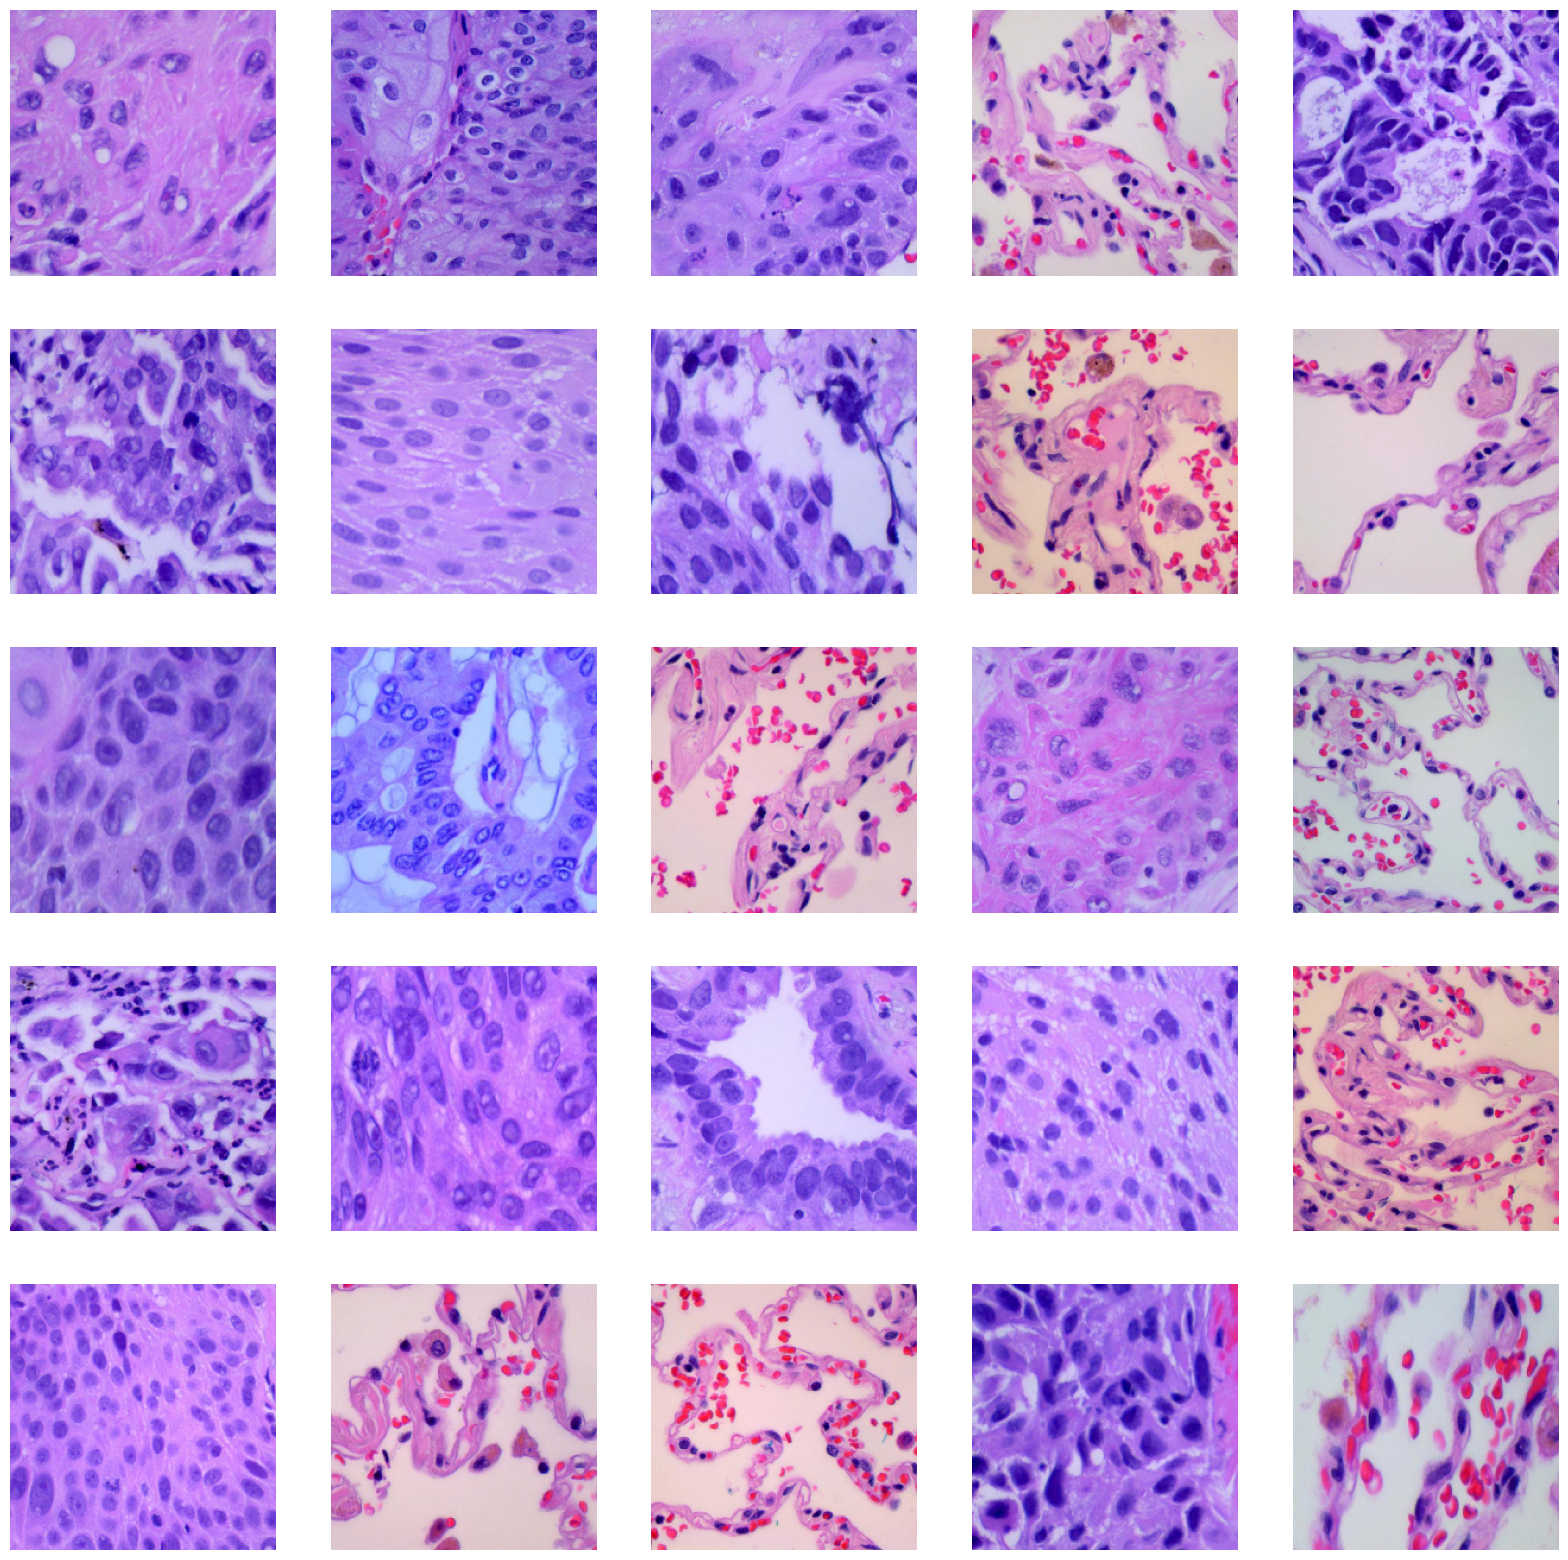

In [29]:
show_image_samples(train_gen)

In [30]:
from keras.applications.vgg19 import VGG19
model_name='VGG19'
base_model = VGG19(input_shape=(224, 224, 3), weights='imagenet', pooling="avg", include_top=False)
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 23s 0us/step
